In [1]:
import pandas as pd
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import words as nltk_words
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import emoji
import swifter

#model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import label_binarize


#visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


#nltk dependency
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('words')

[nltk_data] Downloading package stopwords to /home/wawan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/wawan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /home/wawan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package words to /home/wawan/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [2]:
# loading dataset
# file_name = "blibli_app_review.csv"

data = pd.read_csv('output/blibli_app_review.csv')
data['content'].sample(10, random_state=None)

6171     Jelek saya main game top Eleven tiba² keluar s...
17189    Sengaja install buat nyobain fitur 2 jam sampa...
22429    hai blibli mau curhat dikit hehe. Sbnrnya udah...
20677                     Saya tidak bisa buat login nya👧🙏
9533     harganya ga masuk diakal,mehong2,coba buat bli...
24517                                           Dicoba dlu
26594    Masa mau tukar tambah hpku xiaomi redmi note 4...
1281                                                    ok
19151    kecewa banyak bug ..update sering ..tapi bnyak...
27625    ok sip aplikasi penghasil promo terbaik dan to...
Name: content, dtype: object

In [3]:
#selecting awal

#jika da panjang 'content' hanya senilai 4 atau null, maka drop
data_filtered = data[data['content'].str.split().str.len() >= 4].copy()
data_filtered = data_filtered[data_filtered['content'].str.strip() != '']

#ganti nama score -> rating
data_filtered = data_filtered.rename(columns={'score': 'rating'})

print("Jumlah data orisinil", data.shape)
print("Setelah filter:", data_filtered.shape)
data_filtered.head()

df = data_filtered.copy()

Jumlah data orisinil (40819, 8)
Setelah filter: (28699, 8)


## Rekayasa Fitur

In [4]:
#membuat labeling kelas
def label_sentimen(rating):
    if rating >= 4:
        return 'positif'
    elif rating <= 2:
        return 'negatif'
    else:
        return 'netral'

df['label'] = df['rating'].apply(label_sentimen)
dataframe = df

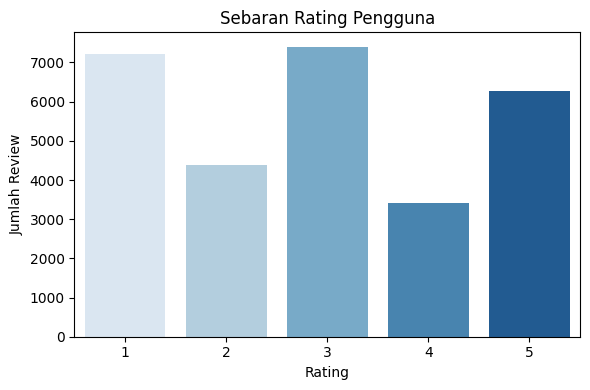

In [5]:
#visualisasi Sebaran Rating

plt.figure(figsize=(6, 4))
sns.countplot(data=dataframe, x='rating', palette='Blues')
plt.title('Sebaran Rating Pengguna')
plt.xlabel('Rating')
plt.ylabel('Jumlah Review')
plt.tight_layout()
plt.show()


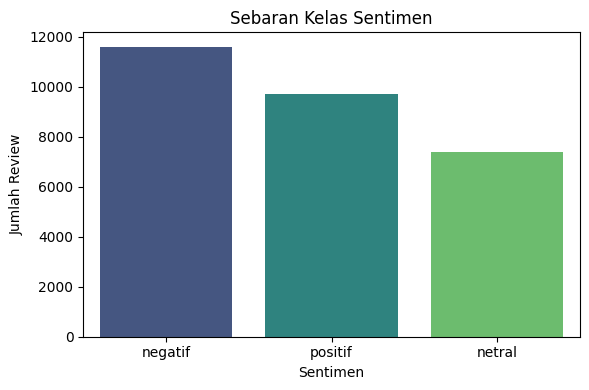

In [6]:
plt.figure(figsize=(6, 4))
sns.countplot(data=dataframe, x='label', palette='viridis')
plt.title('Sebaran Kelas Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Review')
plt.tight_layout()
plt.show()

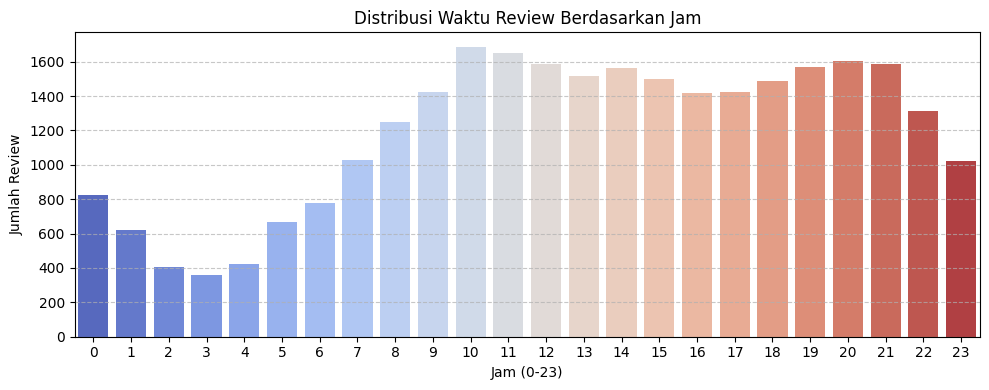

In [7]:
# Distribusi Review pengguna berdasarkan jam
dataframe['created_at'] = pd.to_datetime(dataframe['created_at'], errors='coerce')

df['hour'] = df['created_at'].dt.hour

plt.figure(figsize=(10, 4))
sns.countplot(data=dataframe, x='hour', palette='coolwarm')
plt.title('Distribusi Waktu Review Berdasarkan Jam')
plt.xlabel('Jam (0-23)')
plt.ylabel('Jumlah Review')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Text Preprocessing

In [11]:
positive_df = dataframe[dataframe['label'] == 'positif'].sample(min(2000, dataframe[dataframe['label'] == 'positif'].shape[0]), random_state=42)
netral_df = dataframe[dataframe['label'] == 'netral'].sample(min(2000, dataframe[dataframe['label'] == 'netral'].shape[0]), random_state=42)
negatif_df = dataframe[dataframe['label'] == 'negatif'].sample(min(2000, dataframe[dataframe['label'] == 'negatif'].shape[0]), random_state=42)


sampled_df = pd.concat([positive_df, netral_df, negatif_df])

sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Jumlah data setelah pengambilan 6500 sampel per kelas:", sampled_df.shape)
print("\nSebaran data per kelas setelah sampling:")
print(sampled_df['label'].value_counts())

dataframe = sampled_df.copy()


Jumlah data setelah pengambilan 6500 sampel per kelas: (6000, 10)

Sebaran data per kelas setelah sampling:
label
positif    2000
netral     2000
negatif    2000
Name: count, dtype: int64


In [16]:
def clean_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()

    # Hilangkan newline
    text = re.sub(r'\n', ' ', text)

    # Hilangkan URL
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Hilangkan mention dan hashtag
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)

    # Hilangkan angka dan tanda baca
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)

    # Hilangkan emoji
    text = emoji.replace_emoji(text, replace='')

    # Hilangkan spasi berlebihan
    text = re.sub(r'\s{2,}', ' ', text).strip()

    # Load kamus slang
    path_kamus = 'dataset/slangs.csv'
    kamus = pd.read_csv(path_kamus)
    kamus_dict = dict(zip(kamus['Slang'].astype(str).str.lower(), kamus['Baku'].astype(str).str.lower()))

    # Replacing slang
    words = text.split()
    normalized = [kamus_dict.get(word, word) for word in words]

    return ' '.join(normalized)

In [17]:
dataframe['cleaned'] = dataframe['content'].swifter.apply(clean_text)

Pandas Apply:   0%|          | 0/6000 [00:00<?, ?it/s]

In [19]:
dataframe.shape
dataframe[['content', 'cleaned']].sample(20, random_state=None)

,content,cleaned
2128,Woi asu klo bikin iklan yg jelas lah gw main g...,woi asu kalau buat iklan yang jelas lah saya m...
5995,Ini beneran gratis ongkir gak sih?,ini beneran gratis biaya kirim tidak sih
183,Bro saya mau beli sepatu runing gak ada stok m...,bro saya mau beli sepatu runing tidak ada stok...
5358,Sudah hampir 3 tahun diriku berbelanja Online ...,sudah hampir tahun diriku berbelanja online di...
5777,MANTUL (MANTAP BETUL) 🥰🥰,mantap mantap betul
1312,Jeleknya kalo nagih ke tempat kerja bikin semu...,jeleknya kalau nagih ke tempat kerja buat semu...
5072,Dulu banget pake BliBli harga emang paling mah...,dulu sekali pakai blibli harga emang paling ma...
3154,"Ribet banget belanja nya,aku belum ngerti sii,...",ribet sekali belanja nyaaku belum ngerti siigk...
4260,keren banget bli bli,keren sekali beli beli
5572,Saya coba dulu ya,saya coba dulu ya


In [20]:
import re
import pandas as pd
from collections import Counter

def words(text):
    return re.findall(r'\w+', text.lower())

# Load dari slangs.csv
df = pd.read_csv('dataset/slangs.csv')
basic_words = df['Baku'].dropna().astype(str).str.lower().tolist()

# # Load dari kata_dasar_KBBI.txt
with open('dataset/kata_dasar_KBBI.txt', 'r', encoding='utf-8') as f:
  kbbi_lines = [line.strip().lower() for line in f if line.strip()]
  kbbi_words = []
  for line in kbbi_lines:
    kbbi_words.extend(line.split())

#kata kata bahasa inggris
ENGLISH_WORDS = set(word.lower() for word in nltk_words.words())

BRAND_WORDS = set([
    "blibli", "tokopedia", "bukalapak", "shopee", "lazada",
    "grab", "gojek", "indomaret", "alfamart", "bca", "bni", "bri",
    "mandiri", "gopay", "ovo", "dana", "linkaja", "jnt", "jne", "sicepat", "indomaret", "alfamart",
    "bank"
])

combined_words = basic_words + kbbi_words + list(ENGLISH_WORDS) + list(BRAND_WORDS)
WORD_SET = set(w for w in combined_words if w.strip() and len(w) > 1)
WORDS = Counter(w for w in combined_words if w in WORD_SET)
WORDS = Counter(combined_words)
WORD_SET = set(combined_words)


def P(word, N=sum(WORDS.values())):
    return WORDS[word] / N

def correction(word):
    return max(candidates(word), key=P)

def candidates(word):
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words):
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word):
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def correct_sentence(sentence):
    tokens = re.findall(r'\w+', sentence.lower())
    corrected = [correction(word) for word in tokens]
    return ' '.join(corrected)

def segment(word, dictionary=WORD_SET):
    """Segment word menjadi kata-kata baku valid dari dictionary"""
    n = len(word)
    dp = [None] * (n + 1)
    dp[0] = []

    for i in range(1, n + 1):
        for j in range(i):
            if dp[j] is not None and word[j:i] in dictionary:
                dp[i] = dp[j] + [word[j:i]]
                break
    return dp[-1]

def expand_numeric_repetition(word):
    match = re.match(r'([a-z]+)(\d+)', word)
    if match:
        base, count = match.groups()
        try:
            repeat = int(count)
            return ' '.join([base] * repeat)
        except:
            pass
    return word

def normalize_word(word):
    raw_word = word  # simpan kata asli
    word = re.sub(r'[^\w\s]', '', word.lower())

    # Cek langsung dari raw lowercase
    if raw_word.lower() in BRAND_WORDS:
        return raw_word.lower()

    if word in BRAND_WORDS:
        return word

    if word in ENGLISH_WORDS:
        return word

    expanded = expand_numeric_repetition(word)
    if expanded != word:
        return ' '.join(normalize_word(w) for w in expanded.split())

    if ' ' in word:
        return ' '.join(normalize_word(w) for w in word.split())

    if word in WORD_SET and len(word) > 2:
        return word

    segmented = segment(word)
    if segmented and all(len(w) > 2 for w in segmented):
        return ' '.join(correction(w) for w in segmented)

    return correction(word)

def normalize_sentence(sentence):
    tokens = re.findall(r'\w+', sentence.lower())
    return ' '.join(normalize_word(token) for token in tokens)


In [21]:
#test fungsi
kalimat = "prduk tokpedia ggal apliks bsuk"
print(normalize_word(kalimat))

produk tokopedia gagal aplikasi busuk


In [ ]:
import swifter
dataframe['replaced_slangs'] = dataframe['cleaned'].swifter.apply(correct_sentence)
dataframe['norm_norvig'] = dataframe['replaced_slangs'].swifter.apply(normalize_sentence)
dataframe['normalized_text'] = dataframe['norm_norvig']  # Alias untuk konsistensi


In [ ]:
pd.set_option('display.max_colwidth', None)
dataframe[["cleaned","normalized_text","label"]].sample(20)

,cleaned,normalized_text,label
3182,blibli php masa voucher nempel di akun tidak bisa dipake kuota terbatas aturan kalau kuota terbatas ya jangan semua akun yang lama tidak belanja ditempelin voucher sudah happy dapat vc eh taunya zonkkkk,blibli pop masa voucher tempel di akun tidak bisa diare kuota terbatas aturan kalau kuota terbatas ya jangan semua akun yang lama tidak belanja ditempelin voucher sudah happy dapat v eh tanya zonkkkk,negatif
2795,cashbacknya tidak bisa digunakan leluasa tolong diperbaiki,cash back nya tidak bisa disunahkan leluasa tolong diperbaiki,netral
3519,produk original tanpa ragu belanja barang barang mewah disini,produk original tanpa ragu belanja barang barang mewah dini,positif
550,kenapa susah verifikasi yah,kenapa susah verifikasi yah,netral
1160,sangat baik barang sesuai dengan ke inginan pembeli,sangat baik barang sesuai dengan ke anginan pembeli,positif
4545,tolong tambahkan sistem pembatalan pesan banyak penjual yang molor nunda pesan sampai berhari hari,tolong tambahkan sistem pembatalan pesan banyak penjual yang molor tunda pesan sampai berhari hari,netral
4890,setiap mencari barang layar stucktidak meresponstolong perbaiki,setiap mencari barang layar stuck tidak merespons tolong terbaiki,negatif
5367,tolong fiktur pembatalan pesanan adain kalau consumen berubah pikiran ada barang yang lebih murah mau mesen barang yang lebih murah jadi gampang,tolong faktur pembatalan pesanan adan kalau konsumen berubah pikiran ada barang yang lebih murah mau mesin barang yang lebih murah jadi gampang,negatif
4196,dulu lahbaru klik pay langsung tolak mentah lebih baik blili ngadain pay sendiri ketimbang punya sebelah kaya punya sebelah punya paysendiri bergabunk sama bnk bri bni,dulu lahar klik pay langsung tolak mentah lebih baik lili gadai pay sendiri ketimbang punya sebelah kaya punya sebelah punya pay sendiri bergabung sama bank bri bni,negatif
1690,assalamuaikum semuanya terima kasih banyak aplikasi beli beli saya baru pertama kali menggunakan aplikasi ini alhamdulillah saya mendapatkan handphone secara gratis terima kasih banyak beli beli syarat nya cuma suruh ngumpulin koin doanknyesel kalau tidak unduh hadehh ini aplikasi keren abis,assalamualaikum semuanya terima kasih banyak aplikasi beli beli saya baru pertama kali menggunakan aplikasi ini alhamdulillah saya mendapatkan handphone secara gratis terima kasih banyak beli beli syarat nya cuma suruh ngumpulin koin doanknyesel kalau tidak unduh hadiah ini aplikasi keren abis,positif


###convert negation

In [ ]:
def convert_negation(text):
    negations = {'tidak', 'bukan', 'jangan', 'tak'}
    tokens = word_tokenize(text.lower())
    result = []
    skip_next = False

    for i in range(len(tokens)):
        if skip_next:
            skip_next = False
            continue
        if tokens[i] in negations and i+1 < len(tokens):
            result.append(tokens[i] + '_' + tokens[i+1])
            skip_next = True
        else:
            result.append(tokens[i])

    return ' '.join(result)


In [ ]:
dataframe['convert_negation'] = dataframe['normalized_text'].swifter.apply(convert_negation)
pd.set_option('display.max_colwidth', None)
dataframe[["normalized_text",'convert_negation',"label"]].sample(20)

Pandas Apply: 100%|██████████| 6000/6000 [00:00<00:00, 20154.67it/s]


,normalized_text,convert_negation,label
301,pengiriman kadang lama kadang cepat sesuai estimasi lebih di tingkatan lagi untuk pengiriman produknya untuk belangnya kualitas bagus banget terima kasih,pengiriman kadang lama kadang cepat sesuai estimasi lebih di tingkatan lagi untuk pengiriman produknya untuk belangnya kualitas bagus banget terima kasih,positif
710,menghubungi customer servis sangat susah via telfon tidak bisa live chat tidak bisa via wa tunggu sampai jam tidak ada respon jadi ke inget slovenia waktu mu bangkrut customer service tidak ada yang bisa di hubung,menghubungi customer servis sangat susah via telfon tidak_bisa live chat tidak_bisa via wa tunggu sampai jam tidak_ada respon jadi ke inget slovenia waktu mu bangkrut customer service tidak_ada yang bisa di hubung,negatif
1709,wow mahal mahal broo,wow mahal mahal broo,netral
557,kenapa tidak bisa di buka si,kenapa tidak_bisa di buka si,negatif
5903,sangat bermanfaat dan bagus cek harga,sangat bermanfaat dan bagus cek harga,netral
1541,sans kw sudah memasuki blibli jadi malas lebih baik ke kalor,sans kw sudah memasuki blibli jadi malas lebih baik ke kalor,negatif
864,baru pertama bagus pelayanan nya saran kalau bisa di usahawan pembeli dan pelapak bisa berhubungan hingga bisa cek barang juga pembatalan pesanan walaupun otomatis mesin di berikan lasanya yang bekas jadi tidak asal pembatalan terima kasih ya,baru pertama bagus pelayanan nya saran kalau bisa di usahawan pembeli dan pelapak bisa berhubungan hingga bisa cek barang juga pembatalan pesanan walaupun otomatis mesin di berikan lasanya yang bekas jadi tidak_asal pembatalan terima kasih ya,positif
2978,ini bagus belangnya juga pargana lebih murah,ini bagus belangnya juga pargana lebih murah,netral
3835,bisa bayar dapat tidak,bisa bayar dapat tidak,negatif
4593,promo member baru habis masa,promo member baru habis masa,positif


### Spellchecker : symspell

https://colab.research.google.com/drive/1gQC85Njdkf90chhODCSRuM7t0JaWmZKt?usp=sharing#scrollTo=PuMrVBCTfTNi

In [ ]:
# import os
# import requests
# from symspellpy import SymSpell, Verbosity
# import pandas as pd
# import re

# class SymSpellIndonesia:
#     def __init__(self):
#         self.sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
#         self.setup_dictionary()
    
#     def setup_dictionary(self):
#         """Setup kamus bahasa Indonesia untuk SymSpell"""
        
#         # 1. Load kamus dari file lokal yang sudah ada
#         try:
#             # Load dari KBBI
#             with open('dataset/kata_dasar_KBBI.txt', 'r', encoding='utf-8') as f:
#                 kbbi_words = [line.strip().lower() for line in f if line.strip()]
            
#             # Load dari slangs.csv (kata baku)
#             df_slang = pd.read_csv('dataset/slangs.csv')
#             baku_words = df_slang['Baku'].dropna().astype(str).str.lower().tolist()
            
#             # Gabungkan semua kata
#             all_words = list(set(kbbi_words + baku_words))
            
#             print(f"Loading {len(all_words)} kata Indonesia ke SymSpell...")
            
#             # Tambahkan ke SymSpell dengan frequency default
#             for word in all_words:
#                 if len(word) > 1:  # Skip kata 1 huruf
#                     self.sym_spell.create_dictionary_entry(word, 1)
                    
#         except Exception as e:
#             print(f"Error loading local dictionary: {e}")
#             print("Menggunakan kamus minimal...")
#             # Fallback ke kamus minimal
#             self.create_minimal_dict()
    
#     def create_minimal_dict(self):
#         """Buat kamus minimal jika file tidak ada"""
#         minimal_words = [
#             "aplikasi", "bagus", "jelek", "lambat", "cepat", "mudah", "sulit",
#             "baik", "buruk", "suka", "tidak", "bisa", "error", "lancar",
#             "loading", "crash", "hang", "freeze", "lemot", "mantap", "keren"
#         ]
        
#         for word in minimal_words:
#             self.sym_spell.create_dictionary_entry(word, 100)
    
#     def correct_word(self, word):
#         """Koreksi satu kata"""
#         if len(word) <= 2:
#             return word
            
#         suggestions = self.sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        
#         if suggestions and len(suggestions) > 0:
#             return suggestions[0].term
#         return word
    
#     def correct_sentence(self, sentence):
#         """Koreksi seluruh kalimat"""
#         if pd.isna(sentence):
#             return ""
            
#         # Tokenize
#         words = re.findall(r'\w+', sentence.lower())
        
#         # Koreksi setiap kata
#         corrected_words = [self.correct_word(word) for word in words]
        
#         return ' '.join(corrected_words)

# # Inisialisasi SymSpell Indonesia
# print("Inisialisasi SymSpell Indonesia...")
# symspell_id = SymSpellIndonesia()
# print("SymSpell siap digunakan!")

# # Test fungsi
# test_words = ["apalikasi", "bgus", "jeleg", "lambaat", "tdk", "bsa"]
# print("\n=== TEST SPELL CORRECTION ===")
# for word in test_words:
#     corrected = symspell_id.correct_word(word)
#     print(f"{word} → {corrected}")

# # Test kalimat
# test_sentence = "apalikasi ini bgus tapi agak lambaat loadingya"
# corrected_sentence = symspell_id.correct_sentence(test_sentence)
# print(f"\nKalimat: {test_sentence}")
# print(f"Koreksi: {corrected_sentence}")

Inisialisasi SymSpell Indonesia...
Loading 112719 kata Indonesia ke SymSpell...
SymSpell siap digunakan!

=== TEST SPELL CORRECTION ===
apalikasi → aplikasi
bgus → bagus
jeleg → jelek
lambaat → lambat
tdk → tuk
bsa → bisa

Kalimat: apalikasi ini bgus tapi agak lambaat loadingya
Koreksi: aplikasi ini bagus tapi agak lambat loadingya


In [ ]:
# import time
# import pandas as pd
# from collections import Counter

# # Fungsi untuk tes performa
# def compare_spell_checkers(test_data, sample_size=100):
#     """Bandingkan Norvig vs SymSpell"""
    
#     # Ambil sample data untuk tes
#     sample_data = test_data.sample(min(sample_size, len(test_data)))['cleaned'].tolist()
    
#     results = {
#         'method': [],
#         'time_taken': [],
#         'words_corrected': [],
#         'example_corrections': []
#     }
    
#     print("=== PERBANDINGAN SPELL CHECKER ===\n")
    
#     # 1. Tes Norvig (dari kode asli)
#     print("Testing Norvig...")
#     start_time = time.time()
    
#     norvig_results = []
#     words_corrected_norvig = 0
    
#     for text in sample_data[:10]:  # Sample kecil untuk demo
#         original_words = text.split()
#         corrected = correct_sentence(text)  # Fungsi Norvig dari kode asli
#         corrected_words = corrected.split()
        
#         # Hitung kata yang berubah
#         for orig, corr in zip(original_words, corrected_words):
#             if orig != corr:
#                 words_corrected_norvig += 1
                
#         norvig_results.append(corrected)
    
#     norvig_time = time.time() - start_time
    
#     # 2. Tes SymSpell
#     print("Testing SymSpell...")
#     start_time = time.time()
    
#     symspell_results = []
#     words_corrected_symspell = 0
    
#     for text in sample_data[:10]:  # Sample yang sama
#         original_words = text.split()
#         corrected = symspell_id.correct_sentence(text)
#         corrected_words = corrected.split()
        
#         # Hitung kata yang berubah
#         for orig, corr in zip(original_words, corrected_words):
#             if orig != corr:
#                 words_corrected_symspell += 1
                
#         symspell_results.append(corrected)
    
#     symspell_time = time.time() - start_time
    
#     # Simpan hasil
#     results['method'] = ['Norvig', 'SymSpell']
#     results['time_taken'] = [f"{norvig_time:.4f}s", f"{symspell_time:.4f}s"]
#     results['words_corrected'] = [words_corrected_norvig, words_corrected_symspell]
    
#     # Contoh koreksi
#     results['example_corrections'] = [
#         norvig_results[0] if norvig_results else "N/A",
#         symspell_results[0] if symspell_results else "N/A"
#     ]
    
#     # Tampilkan hasil
#     comparison_df = pd.DataFrame(results)
#     print("\n=== HASIL PERBANDINGAN ===")
#     print(comparison_df.to_string(index=False))
    
#     # Contoh detail
#     print(f"\n=== CONTOH KOREKSI ===")
#     if len(sample_data) > 0:
#         original = sample_data[0]
#         print(f"Original : {original}")
#         print(f"Norvig   : {norvig_results[0] if norvig_results else 'N/A'}")
#         print(f"SymSpell : {symspell_results[0] if symspell_results else 'N/A'}")
    
#     return comparison_df

# # Fungsi untuk implementasi SymSpell dalam pipeline
# def apply_symspell_correction(dataframe, column_name='cleaned'):
#     """Terapkan SymSpell ke dataframe"""
    
#     print(f"Menerapkan SymSpell correction ke kolom '{column_name}'...")
#     start_time = time.time()
    
#     # Gunakan swifter untuk parallel processing
#     dataframe['symspell_corrected'] = dataframe[column_name].swifter.apply(
#         lambda x: symspell_id.correct_sentence(x) if pd.notna(x) else ""
#     )
    
#     end_time = time.time()
#     print(f"SymSpell correction selesai dalam {end_time - start_time:.2f} detik")
    
#     return dataframe

# # Fungsi untuk evaluasi kualitas koreksi
# def evaluate_corrections(dataframe, original_col, corrected_col, sample_size=20):
#     """Evaluasi kualitas koreksi secara manual"""
    
#     sample_df = dataframe[[original_col, corrected_col]].sample(sample_size)
    
#     print(f"=== EVALUASI KUALITAS KOREKSI ({sample_size} sampel) ===\n")
    
#     changes_count = 0
#     for idx, row in sample_df.iterrows():
#         original = row[original_col]
#         corrected = row[corrected_col]
        
#         if original != corrected:
#             changes_count += 1
#             print(f"Before: {original}")
#             print(f"After : {corrected}")
#             print("-" * 50)
    
#     print(f"\nTotal perubahan: {changes_count}/{sample_size} ({changes_count/sample_size*100:.1f}%)")
    
#     return sample_df

In [ ]:
# # Cell 15 - Ganti dengan SymSpell
# import swifter

# # Opsi 1: Pakai SymSpell (RECOMMENDED)
# print("Menggunakan SymSpell untuk spell correction...")
# dataframe['symspell_corrected'] = dataframe['cleaned'].swifter.apply(
#     lambda x: symspell_id.correct_sentence(x) if pd.notna(x) else ""
# )

# # Opsi 2: Bandingkan keduanya
# print("Menggunakan Norvig untuk perbandingan...")
# dataframe['norvig_corrected'] = dataframe['cleaned'].swifter.apply(correct_sentence)

# # Pilih yang mana yang akan digunakan untuk step selanjutnya
# dataframe['normalized_text'] = dataframe['symspell_corrected']  # Atau 'norvig_corrected'

# print("Spell correction selesai!")

In [ ]:
# # Cell baru untuk evaluasi
# # Bandingkan performa
# comparison_results = compare_spell_checkers(dataframe, sample_size=50)

# # Evaluasi kualitas
# print("\n=== EVALUASI SYMSPELL ===")
# evaluate_corrections(dataframe, 'cleaned', 'symspell_corrected', sample_size=10)

# print("\n=== EVALUASI NORVIG ===") 
# evaluate_corrections(dataframe, 'cleaned', 'norvig_corrected', sample_size=10)

###Stopword Removals

In [ ]:
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

def remove_stopwords(text):
    return stopword.remove(text)

dataframe['no_stopwords'] = dataframe['convert_negation'].swifter.apply(remove_stopwords)

dataframe[['cleaned','no_stopwords' ,'label']].sample(20)


Pandas Apply: 100%|██████████| 6000/6000 [00:00<00:00, 75479.21it/s]


,cleaned,no_stopwords,label
979,dulu ys bintangnya,dulu yg bintangnya,netral
295,tolong ya blibli kalau pengiriman pada hari yang sama itu pengiriman di hari yang sama bukan bsk baru di kirimpadahal barang sudah di hub cawang dari jam dan pengantaran ke rumah saya tidak sampai mnt tapi kurir dari bes sd percobaan pengiriman sampai x saya sudah x pakai pengiriman pada hari yang sama dan pakai bes sd selalu di kirim besok na bukan di hari yang sama tolong kalau bes sd tidak bisa ngirim di hari yang sama ganti kurir yang lainsaya atau customer tidak ingin tahu kalau ada masalah atau tidak tapi customer pgn hari sama,ya blibli kalau pengiriman hari sama pengiriman hari sama bukan_bak baru kirim padahal barang hub cawang jam pengantaran rumah tidak_sampai mant kurir bes sd percobaan pengiriman x sudah x pakai pengiriman hari sama pakai bes sd selalu kirim besok na bukan_di hari sama kalau bes sd tidak_bisa pengirim di hari sama ganti kurir gainsay customer tidak_ingin tahu kalau masalah tidak_tapi customer hari sama,negatif
2875,semoga cepat sampai kiriman nya,semoga cepat kiriman nya,positif
2105,bisa bayar ditempat tidak masih,bayar tempat tidak_masih,positif
1639,pakai blibli lancar baeang sesuai,pakai blibli lancar barang sesuai,positif
5747,pelayanan terbaik tidak di ragukan lagi pesan dengan nominal besar tetap sampai tujuan degan aman sangat amanah,pelayanan terbaik tidak_di pasukan pesan nominal besar tetap tujuan degan aman sangat amanah,positif
573,banyak penjual tidak aktif,banyak penjual tidak_aktif,negatif
4580,ini yang saya cari slm ini,yang cari sim,positif
5395,platform belanja terbaik saya sangat puas berbelanja disini karena estimasi pengiriman cepat dan barang yang dijual di blibli kerenkeren sekali deh saya sangat puas berbelanja di blibli,platform belanja terbaik sangat puas berbelanja dini estimasi pengiriman cepat barang dijual blibli keren keren sekali deh sangat puas berbelanja blibli,positif
126,tiga dulu law bagus baru nambah lagi,tiga dulu law bagus baru tambah,netral


###Stemming


In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
  return stemmer.stem(text)

dataframe['stemmed'] = dataframe['no_stopwords'].swifter.apply(stemming)

Pandas Apply: 100%|██████████| 6000/6000 [02:31<00:00, 39.55it/s] 


In [ ]:
dataframe[['stemmed','label']].sample(10)

,stemmed,label
3691,mantap cash on delivery murah,positif
575,proses cepat pac king cukup rapih alangkah bagus nya pesan nya angin batas,positif
2622,tahu pernah belanja ondine,netral
1220,hi blibli produk tawar bagus sayang sekali aplikasi sangat buruk bukti perangkat jaring sama laku transaksi di toko ondine lebih sederhana cepat,negatif
1008,turun bintang tidak gratis ongkos kirim se indonesia mohon maaf,netral
5819,buku beri dulu bintang kalau bagus akutambahin,netral
4029,aplikasi rusak jelek masa baru masuk aplikasi las henti,negatif
3173,hari pesan progres seller tidak mampu kirim berangga opsi bata pesan tetap bagus tokopedia,negatif
3941,coba dulu kalau bagus bintang tambak,netral
5630,sangat puas belanja blibli kualitas belang bagus seler nya respons cepat,positif


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataframe['stemmed'], dataframe['label'], test_size=0.2, random_state=42, stratify=dataframe['label'])

# Inisialisasi TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Shape X_train_tfidf:", X_train_tfidf.shape)
print("Shape X_test_tfidf:", X_test_tfidf.shape)


Shape X_train_tfidf: (4800, 5000)
Shape X_test_tfidf: (1200, 5000)


###Eksperimen : Spellcheceker pake levenstein distance

Hasil : Levenstein distance gagal menangkap konteks perbaikan


In [ ]:
# #spellcheceker 2
# import pandas as pd
# import re
# from gensim.models import Word2Vec

# # --- 1. LOAD DATA ---
# # Asumsi dataframe sudah tersedia, kalau belum:
# # dataframe = pd.read_csv('namafile.csv')

# # --- 2. PREPROCESS: Tokenisasi Kolom 'cleaned' jadi list of words ---
# sentences = dataframe['cleaned'].dropna().apply(lambda s: re.findall(r'\w+', s.lower())).tolist()

# # --- 3. LATIH MODEL WORD2VEC ---
# model = Word2Vec(
#     sentences=sentences,
#     vector_size=100,
#     window=5,
#     min_count=1,
#     workers=4,
#     sg=1  # CBOW=0, Skip-gram=1 (biasanya skip-gram lebih baik untuk typo)
# )

# # --- 4. SPELL CHECK FUNCTION ---
# def w2v_spell_checker(word, model, threshold=0.7):
#     try:
#         similar_words = model.wv.most_similar(word, topn=5)
#         for sim_word, score in similar_words:
#             if score >= threshold:
#                 return sim_word
#     except KeyError:
#         pass
#     return word  # fallback: tidak ditemukan

# # --- 5. NORMALISASI KALIMAT DENGAN SPELL CHECKING ---
# def normalize_with_w2v(sentence, model):
#     tokens = re.findall(r'\w+', sentence.lower())
#     corrected = [w2v_spell_checker(word, model) for word in tokens]
#     return ' '.join(corrected)

# # --- 6. APPLY KE DATAFRAME ---
# dataframe['corrected_sentence'] = dataframe['cleaned'].apply(lambda s: normalize_with_w2v(s, model))

                                             cleaned  \
0    gimana crnya sih kredit tidak pakai krtu kredit   
1  pertahankan dan pastikan hanya produk original...   
2              saya sangat puas dengan pelayanan ini   
3  saya sangat aktif berbelanja online tapi munur...   
4  proses pesanan lama sudah bayar lunas pas di b...   

                                  corrected_sentence  
0         atm kolom sayang kartu kok apa doang kartu  
1  sebelumnya orisinil justru jualan mengecewakan...  
2       kali membantu suka yang berkualitas aplikasi  
3  kali membantu stok terpercaya shop pas premium...  
4  lama lama proses pesan bisa klik terus apa nom...  


In [ ]:
# pd.set_option('display.max_colwidth', None)
# dataframe[['cleaned', 'corrected_sentence']].sample(10)

In [ ]:

dataframe[["cleaned","normalized_text","label"]].sample(10)

,cleaned,normalized_text,label
65,perbanyakin lagi barangnyasoalnya masi ada jenis oli motorseperti castrol maticfederal oil maticok terima kasih,perbanyakan lagi barang nya soal nya mati ada jenis oli motor seperti castral maticfederal oil matico terima kasih,netral
5848,aku akan tambah bila semua bisa cash on delivery ya,aku akan tambah bila semua bisa cash on delivery ya,netral
3236,aplikasinya bagus sekali buat belanjaa sama cash on delivery an jugaa suka deh,aplikasinya bagus sekali buat belanja sama cash on delivery an juga suka deh,positif
1914,hallo kok gratis biaya kirim saya tidak muncul lagi ya padahal baru di pakai kali belanja masih ada x lagi gratis ongkirnya,halo kok gratis biaya kirim saya tidak muncul lagi ya padahal baru di pakai kali belanja masih ada x lagi gratis ongkir nya,negatif
3664,mempermudah dalam belanja onlineharga bersaing,mempermudah dalam belanja onlineharga bersaing,positif
1988,baik sekali blibli menyelesaikan problem walaupun masih ada kekurangan misscomm antara pihak blibli dengan indodana,baik sekali blibli menyelesaikan problem walaupun masih ada kekurangan misscomm antara pihak blibli dengan indogaea,positif
2602,saya mengajukan bayar nanti gagal karena lokasi jauh dari jangkauan layanan mungkin takut tidak dibayar kalau jauh,saya mengajukan bayar nanti gagal karena lokasi jauh dari jangkauan layanan mungkin takut tidak dibayar kalau jauh,negatif
2161,belanja online oke sekali,belanja ondine oke sekali,netral
5293,aku baru masuk di blibli semog lancar,aku baru masuk di blibli semoga lancar,positif
2155,nice aplikasi tolong di perbaiki beberapa metode pembayaran yang masih suka error,nice aplikasi tolong di terbaiki beberapa metode pembayaran yang masih suka error,positif


## Modeling Naive Bayes

Accuracy: 0.6875
Precision: 0.6882
Recall: 0.6875
ROC AUC Score (multiclass - OvR): 0.8399


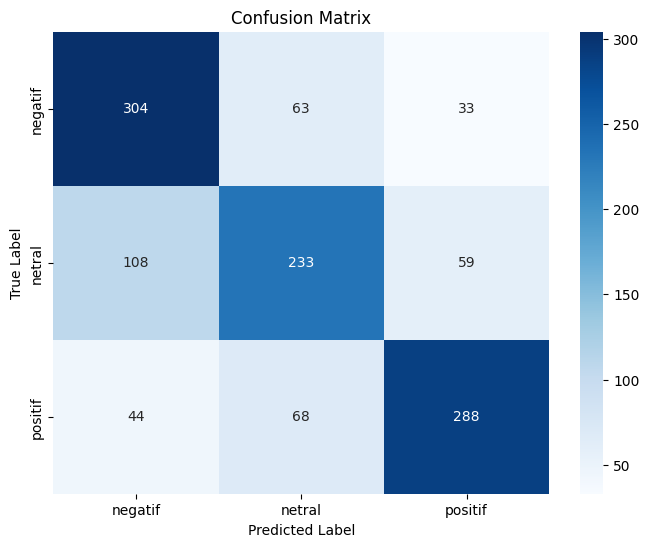

In [37]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

# Training
model = MultinomialNB(alpha=1.0, force_alpha=True, fit_prior=True)
model.fit(X_train_tfidf, y_train)

# Prediksi label
y_pred = model.predict(X_test_tfidf)

# Hitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Hitung precision
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")

# Hitung recall
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {recall:.4f}")

# Hitung ROC AUC Score
# Dapatkan probabilitas dari model
y_score = model.predict_proba(X_test_tfidf)

# Binarisasi label y_test untuk multiclass AUC
classes = model.classes_
y_test_binarized = label_binarize(y_test, classes=classes)

# ROC AUC Score
roc_auc = roc_auc_score(y_test_binarized, y_score, multi_class='ovr', average='macro')
print(f"ROC AUC Score (multiclass - OvR): {roc_auc:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


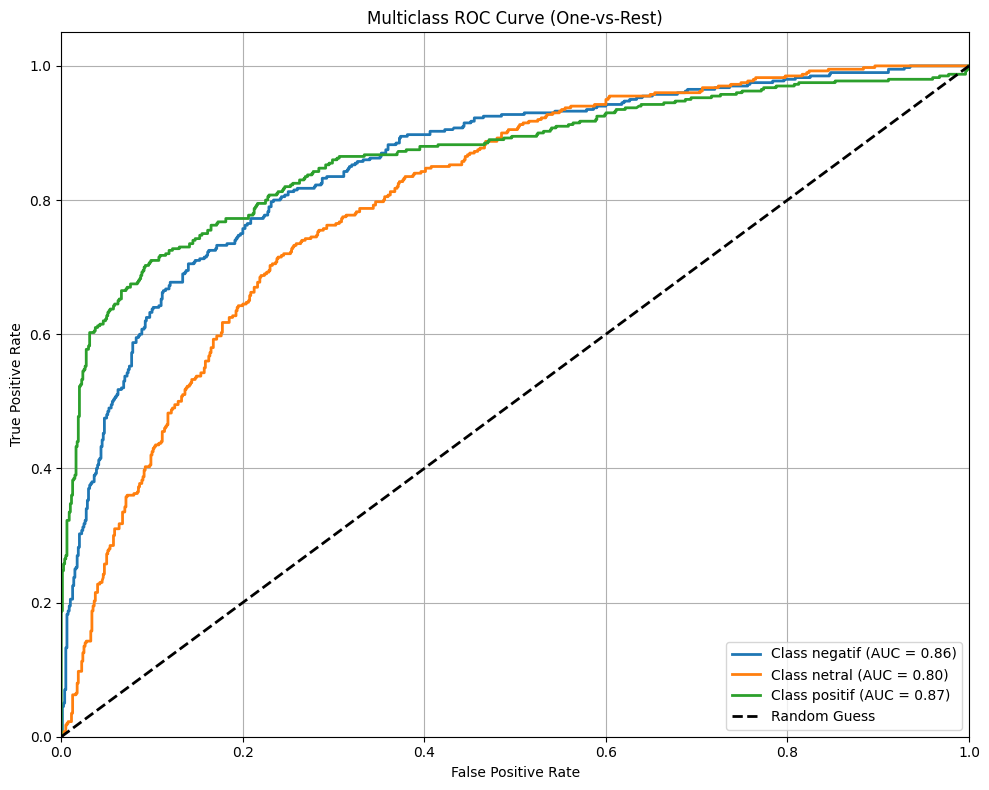

In [40]:
# Probabilitas prediksi
y_prob = model.predict_proba(X_test_tfidf)

lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

classes = lb.classes_
n_classes = len(classes)

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB, ComplementNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.exceptions import NotFittedError

# Siapkan DataFrame hasil evaluasi
results = []

# Daftar model yang ingin diuji
models = {
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),
    "GaussianNB": GaussianNB(),
    "ComplementNB": ComplementNB()
}

# Loop semua model
for model_name, model in models.items():
    try:
        # GaussianNB butuh array, bukan sparse matrix
        if model_name == "GaussianNB":
            model.fit(X_train_tfidf.toarray(), y_train)
            y_pred = model.predict(X_test_tfidf.toarray())
            y_proba = model.predict_proba(X_test_tfidf.toarray())
        else:
            model.fit(X_train_tfidf, y_train)
            y_pred = model.predict(X_test_tfidf)
            y_proba = model.predict_proba(X_test_tfidf)

        # Hitung metrik
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        # ROC AUC multiclass (OvR)
        y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
        roc_auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')

        # Simpan ke results
        results.append({
            "Model": model_name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1,
            "ROC AUC": roc_auc
        })

    except Exception as e:
        # Tangani error model (misalnya tidak support proba, dsb)
        print(f"Model {model_name} error: {e}")
        continue

# Buat dataframe hasil evaluasi dan sorting
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

# Tampilkan hasil akhir
print("Hasil Evaluasi Model Naive Bayes (sorted by F1-Score):")
results_df_sorted


Hasil Evaluasi Model Naive Bayes (sorted by F1-Score):


,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,MultinomialNB,0.687500,0.688224,0.687500,0.686230,0.839882
1,BernoulliNB,0.677500,0.698679,0.677500,0.679577,0.832484
2,ComplementNB,0.678333,0.677567,0.678333,0.675859,0.841392
3,GaussianNB,0.593333,0.601679,0.593333,0.592000,0.702317


## Evaluasi - Hindia

## Referensi